# GLOVe-Logistic Regression
- Uses logistic regression on GloVe embedding representation of tweets

In [1]:
## IMPORTS
# GLOVE Embeddings
import spacy

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

# GLOVE Embeddings
import spacy

# Preprocessing
import csv
import chardet
import numpy as np
import re
import pandas as pd
import demoji
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import json

# metrics
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/walnuts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load the dataset / read csv
# MAKE SURE CSV IS IN UTF-8 (if tweets have emojis)

## Testing if csv can open (Use for troubleshooting)
# with open('Eng_Tweets.csv') as csv_file:
#   csvFile = csv.reader(csv_file, delimiter=',')
#   for row in csv_file:
#     print(row)

# RUN PARAMETERS
LANG = 4  # 1 = English | 2 = Tagalog | 3 = TagLish | 4 = Mixed

pd.set_option('display.max_colwidth', None)

# Assign the CSV path based on LANG value
if LANG == 1:
    csv_path = 'Eng_Tweets.csv'
elif LANG == 2:
    csv_path = 'Tag_Tweets.csv'
elif LANG == 3:
    csv_path = 'TagLish_Tweets.csv'
elif LANG == 4:
    csv_path = 'Mixed_Tweets.csv'
else:
    raise ValueError("Invalid value for LANG. Must be 1, 2, 3, or 4.")

df = pd.read_csv(csv_path)
print("total rows: " + str(len(df)))
df.head() ## head won't show emojis unless using print function

total rows: 4995


,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going to attempt tonight i can't do this anymore i can't handle all this stress i wish i was never born bro,9/11/24,1.0
1,@yourdystiny,"Becoming less reactive is a huge part of growth & decreasing stress. If you let everything get you worked up, you’ll damage your mind, body & spirit.",9/8/24,0.0
2,@ocenhxu,me ??? tired ??? stressed ??? exhausted ??? i wanna cry ??? yes.,9/8/24,1.0
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired and drained. that's me, that's my everyday life",9/10/24,1.0
4,@ysuckme,"you deserve to be happy. not confused, not hurt, not stressed, just happy.",9/8/24,0.0


In [4]:
df.loc[22]

Username                                            @PaulKagame
Tweet          After this conversation no stress at all !!!😁😁😍😍
Date posted                                             2/24/23
Label                                                       0.0
Name: 22, dtype: object

In [6]:
df['Label'].value_counts()

Label
0.0    3659
1.0    1335
Name: count, dtype: int64

## Preprocessing
- Remove mentions (@)
- Remove hashtags (#)
- Remove URLs
- Replace emojis with textual description (Using demoji)
- Remove stop words

In [7]:
### PREPROCESSING STEPS (FOR TAGALOG)
with open('tl_stopwords.json', 'r') as f:
    tagalog_stop_words = json.load(f)

# Preprocessing functions
def clean_text_tl(text):
    # Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Replace emoji with textual descriptions
    text = demoji.replace_with_desc(text)
    text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text)  # Add spaces around the shortcode
    text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
    text = text.strip()
    return text

def remove_stopwords_tl(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in tagalog_stop_words]
    return ' '.join(filtered_words)

In [8]:
### PREPROCESSING STEPS
def clean_text(text):
  # Remove mentions
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  # Remove hashtags
  text = re.sub(r'#\w+', '', text)
  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  # Replace emoji with textual descriptions
  text = demoji.replace_with_desc(text)
  text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text) # Add spaces around the shortcode
  text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
  text = text.strip()
  return text

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

In [9]:
## Execute preprocessing
df = df.dropna()  # Get rid of NaN rows

if LANG == 1:
    print("EXECUTING TAGALOG TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text_tl)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords_tl)
else:
    print("EXECUTING ENGLISH TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)

df.head()

EXECUTING ENGLISH TWEET CLEANING


,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going attempt tonight can't anymore can't handle stress wish never born bro,9/11/24,1.0
1,@yourdystiny,"Becoming less reactive huge part growth & decreasing stress. let everything get worked up, you’ll damage mind, body & spirit.",9/8/24,0.0
2,@ocenhxu,??? tired ??? stressed ??? exhausted ??? wanna cry ??? yes.,9/8/24,1.0
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired drained. that's me, that's everyday life",9/10/24,1.0
4,@ysuckme,"deserve happy. confused, hurt, stressed, happy.",9/8/24,0.0


In [10]:
df['Label'].value_counts()

Label
0.0    3659
1.0    1335
Name: count, dtype: int64

In [11]:
df.loc[22]

Username                                                                                                                                        @PaulKagame
Tweet          conversation stress !!! :beaming_face_with_smiling_eyes: :beaming_face_with_smiling_eyes: :smiling face heart-eyes::smiling face heart-eyes:
Date posted                                                                                                                                         2/24/23
Label                                                                                                                                                   0.0
Name: 22, dtype: object

## GloVe Embeddings
- Make sure to run "python -m spacy download en_core_web_md"
- GloVe embeddings are then averaged and standardized
- Train-Test-Validation split = 70% - 20% - 10%
- Uses undersampling to balance the training set
- Uses standard scaler for standardization of values

In [12]:
nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner"]) # disable non word-embedding parts of spacy

# Create an empty list to store the embeddings
embeddings = []

# Iterate through the DataFrame
for index, row in df.iterrows():
    tweet = row['Tweet']
    doc = nlp(tweet)

    # Get the embeddings for each token and store them
    tweet_embeddings = [token.vector for token in doc]
    embeddings.append(tweet_embeddings)

# Add the embeddings to the DataFrame as a new column
df['embeddings'] = embeddings

/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check

In [18]:
# Function to average embeddings for a tweet
def average_embeddings(embeddings_list):
    if embeddings_list:
        return np.mean(embeddings_list, axis=0)
    else:
        return np.zeros(300)  # 300 = embedding dimenstion

In [19]:
# Function to split the dataset into train, validation, and test
def split_data(df, train_size=0.7, val_size=0.1, test_size=0.2):
    # 70% into training 30% into validation + testing 
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42)
    
    # 30% splits 10% into validation and 20% into testing
    val_df, test_df = train_test_split(temp_df, train_size=val_size / (val_size + test_size), random_state=42)
    
    return train_df, val_df, test_df

In [20]:
## WITH IMBALANCED DATASET
# Average the sentence embedding into a single entry
df['avg_embedding'] = df['embeddings'].apply(average_embeddings)

# Split the dataset
train_df, val_df, test_df = split_data(df)

X_train = np.array(train_df['avg_embedding'].to_list())
y_train = train_df['Label']
X_val = np.array(val_df['avg_embedding'].to_list())
y_val = val_df['Label']
X_test = np.array(test_df['avg_embedding'].to_list())
y_test = test_df['Label']

## PICK ONE OF THESE
# Undersample the training set to balance the classes
# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)  # balances classes
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Oversample the training set to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Optionally, check the class distribution after undersampling
print(f"Class distribution after undersampling:\n{pd.Series(y_train_resampled).value_counts()}")

# Standardization
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)  # Apply scaling to the resampled data
X_test = scaler.transform(X_test)  # Apply scaling to the test data
X_val = scaler.transform(X_val)  # Apply scaling to the validation data

Class distribution after undersampling:
Label
1.0    2580
0.0    2580
Name: count, dtype: int64


## Logistic Regression

In [23]:
# Train and evaluate logistic regression with validation
model = LogisticRegression(max_iter = 1000, verbose=True)
model.fit(X_train_resampled, y_train_resampled)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          301     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.75316D-01

At iterate   50    f=  3.64965D-01    |proj g|=  4.20488D-03


 This problem is unconstrained.



At iterate  100    f=  3.59327D-01    |proj g|=  1.74677D-03

At iterate  150    f=  3.58412D-01    |proj g|=  7.16723D-04

At iterate  200    f=  3.58272D-01    |proj g|=  1.82126D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  301    222    244      1     0     0   8.126D-05   3.583D-01
  F =  0.35825344718824220     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


LogisticRegression(max_iter=1000, verbose=True)

## Metrics
- Validation set
    - Accuracy
    - Precision
    - Recall
    - F1 Score
    - Balanced Accuracy
    - Confusion Matrix
- Test Set
    - Accuracy
    - Precision
    - Recall
    - F1 Score
    - Balanced Accuracy
    - Confusion Matrix
- ROC AUC

Validation Accuracy: 0.7675350701402806
Validation Precision: 0.5743589743589743
Validation Recall: 0.7724137931034483
Validation F1 Score: 0.6588235294117647
Validation Balanced Accuracy: 0.7689752581336451
Validation Confusion Matrix: 
[[271  83]
 [ 33 112]]
Test Accuracy: 0.735
Test Precision: 0.5135869565217391
Test Recall: 0.6872727272727273
Test F1 Score: 0.5878693623639192
Test Balanced Accuracy: 0.7201880877742947
Test Confusion Matrix: 
[[546 179]
 [ 86 189]]
Test ROC AUC: 0.7956263322884012


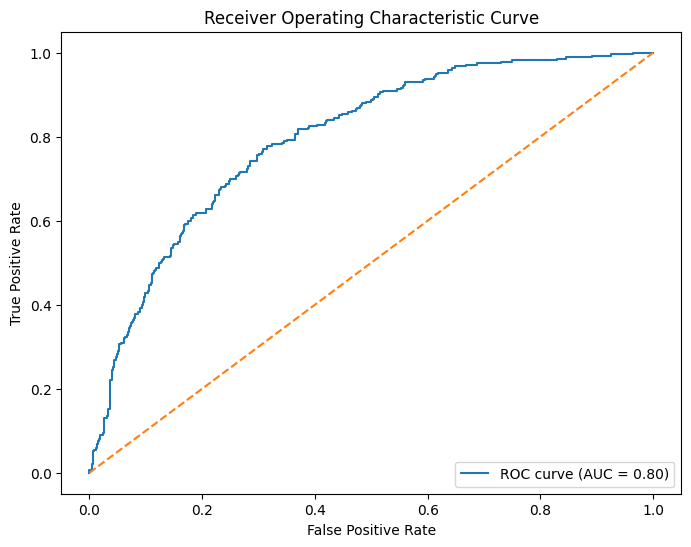

In [24]:
# Evaluation on validation set
y_pred_val = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
balanced_acc_val = balanced_accuracy_score(y_val, y_pred_val)  # Add balanced accuracy
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")
print(f"Validation Balanced Accuracy: {balanced_acc_val}")  # Print balanced accuracy
print(f"Validation Confusion Matrix: \n{conf_matrix_val}")

# Final evaluation on test set
y_pred_test = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)  # Add balanced accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test Balanced Accuracy: {balanced_acc_test}")  # Print balanced accuracy
print(f"Test Confusion Matrix: \n{conf_matrix_test}")

# Compute ROC AUC
y_prob_test = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_prob_test)
print(f"Test ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()


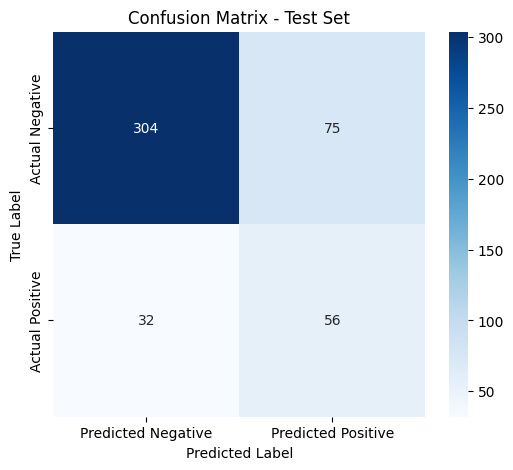

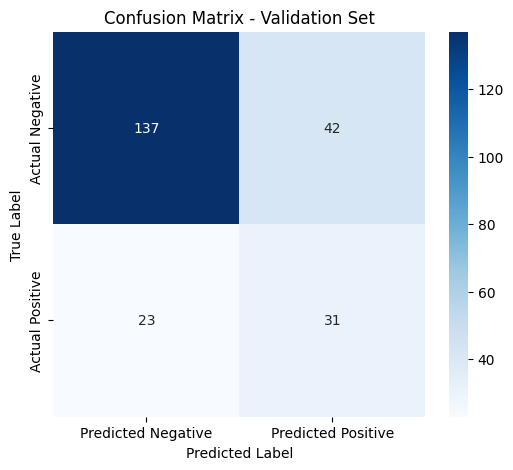

In [14]:
# Plot confusion matrix for test set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Final Training Score: 0.8617
Final Cross-validation Score: 0.8277


/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklear

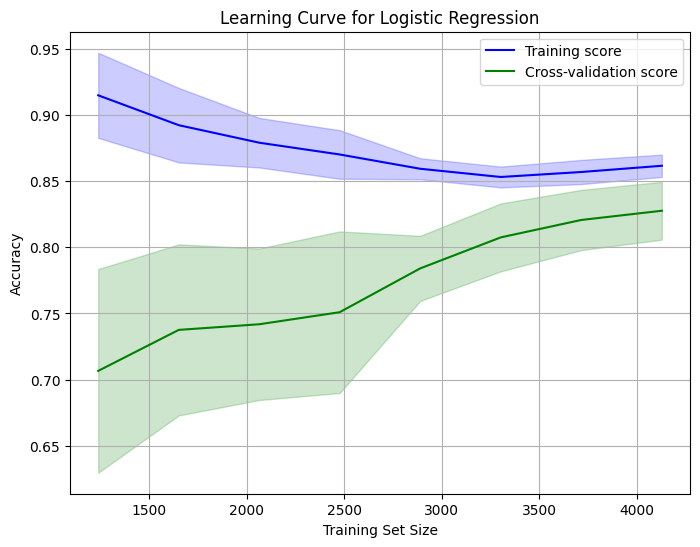

In [25]:
# Assuming you have already defined and resampled your data
# X_train_resampled and y_train_resampled should be your training data and target

# Initialize StratifiedKFold with 5 splits
stratified_cv = StratifiedKFold(n_splits=5)

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_resampled, y_train_resampled, cv=stratified_cv,  # Use StratifiedKFold
    scoring='accuracy',  # Score using accuracy
    train_sizes=np.linspace(0.1, 1.0, 10),  # Training sizes from 10% to 100%
    n_jobs=-1  # Parallel processing
)

# Calculate the mean and standard deviation of train and test scores
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Print the final scores (for the largest training set size)
print(f"Final Training Score: {train_scores_mean[-1]:.4f}")
print(f"Final Cross-validation Score: {test_scores_mean[-1]:.4f}")

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='green')

# Fill the area between the curve and the axis to represent the standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.2)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Logistic Regression')
plt.legend(loc='best')
plt.grid(True)
plt.show()
